# Parcial 1
Prgunta 5

El objetivo de este cuadernillo es el de utilizar un modelo preentrenado en este caso CONVNEXT para la clasificacion de residuos solidos

Se utilizara el dataset Taco https://github.com/pedropro/TACO

In [1]:
import torch
import torch.nn as nn
import torchvision
import random
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
import numpy as np
import pandas as pd
import math
import zipfile
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
with zipfile.ZipFile('drive/MyDrive/Colab Notebooks/Taco.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Se carga el dataset

In [80]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('Taco', transform=data_transform)
print('Imagenes:',len(dataset))
print('Numeros de clases:',len(os.listdir('Taco')))

Imagenes: 2527
Numeros de clases: 6


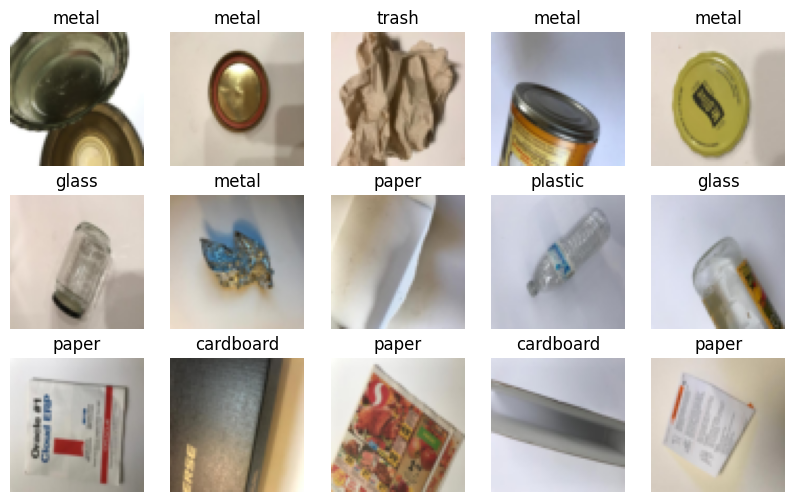

In [81]:
classes = sorted(os.listdir('Taco'), key=lambda x: x.lower())
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset)-1)
    img, lab = dataset[ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

Se divide el dataset en conjunto de entrenamiento y prueva

In [82]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train size: 2021
test size: 506


Se crea dataloaders

In [83]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
dataloader = {
    'train': train_loader,
    'test': test_loader
}

In [84]:
imgs, labels = next(iter(train_loader))
print('Forma Xi:',imgs.shape)

Forma Xi: torch.Size([32, 3, 64, 64])


Se define el modelo

In [94]:
class Model(torch.nn.Module):
    def __init__(self, n_outputs=5, freeze=False):
        super().__init__()
        # descargamos convnext
        convnext = torchvision.models.convnext_base(weights='DEFAULT')
        #convnext = torchvision.models.convnext_large(weights='DEFAULT')
        # nos quedamos con todas las capas menos la última
        self.convnext = torch.nn.Sequential(*list(convnext.children())[:-1])
        if freeze:
            for param in self.convnext.parameters():
                param.requires_grad = False
        # añadimos una nueva capa lineal para llevar a cabo la clasificación
        self.fc = torch.nn.Linear(1024, 6)
        #self.fc = torch.nn.Linear(1536, 6)

    def forward(self, x):
        x = self.convnext(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.convnext.parameters():
            param.requires_grad = True

Se define la funcion encarga del entrenamiento

In [98]:
def fit(model, dataloader, epochs=5, lr=1e-2, r=1e-4):
    optimizer = torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=r)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.cuda(), y.cuda()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


In [99]:
model = Model(freeze=True).cuda()
fit(model, dataloader, epochs=5)
model.unfreeze()
fit(model, dataloader, epochs=10, lr=1e-4, r=1e-2)

val_loss 0.64260 val_acc 0.78726: 100%|██████████| 16/16 [00:01<00:00,  8.72it/s]


Epoch 1/5 loss 0.92183 val_loss 0.64260 acc 0.68828 val_acc 0.78726


val_loss 0.56360 val_acc 0.80589: 100%|██████████| 16/16 [00:01<00:00,  8.70it/s]


Epoch 2/5 loss 0.57600 val_loss 0.56360 acc 0.78330 val_acc 0.80589


val_loss 0.50405 val_acc 0.83413: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 3/5 loss 0.48518 val_loss 0.50405 acc 0.82939 val_acc 0.83413


val_loss 0.48346 val_acc 0.84390: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]


Epoch 4/5 loss 0.44070 val_loss 0.48346 acc 0.84893 val_acc 0.84390


val_loss 0.51823 val_acc 0.82437: 100%|██████████| 16/16 [00:01<00:00,  8.86it/s]


Epoch 5/5 loss 0.38883 val_loss 0.51823 acc 0.86670 val_acc 0.82437


val_loss 0.39930 val_acc 0.87996: 100%|██████████| 16/16 [00:01<00:00, 10.70it/s]


Epoch 1/10 loss 0.33251 val_loss 0.39930 acc 0.87920 val_acc 0.87996


val_loss 0.40127 val_acc 0.87605: 100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


Epoch 2/10 loss 0.15300 val_loss 0.40127 acc 0.94316 val_acc 0.87605


val_loss 0.41288 val_acc 0.87410: 100%|██████████| 16/16 [00:01<00:00, 10.50it/s]


Epoch 3/10 loss 0.12423 val_loss 0.41288 acc 0.95322 val_acc 0.87410


val_loss 0.40156 val_acc 0.87800: 100%|██████████| 16/16 [00:01<00:00, 10.31it/s]


Epoch 4/10 loss 0.08676 val_loss 0.40156 acc 0.96875 val_acc 0.87800


val_loss 0.41362 val_acc 0.89408: 100%|██████████| 16/16 [00:01<00:00, 10.41it/s]


Epoch 5/10 loss 0.06790 val_loss 0.41362 acc 0.98047 val_acc 0.89408


val_loss 0.37874 val_acc 0.89168: 100%|██████████| 16/16 [00:02<00:00,  7.77it/s]


Epoch 6/10 loss 0.05903 val_loss 0.37874 acc 0.97900 val_acc 0.89168


val_loss 0.43020 val_acc 0.88431: 100%|██████████| 16/16 [00:01<00:00,  9.44it/s]


Epoch 7/10 loss 0.07283 val_loss 0.43020 acc 0.97461 val_acc 0.88431


val_loss 0.38546 val_acc 0.89994: 100%|██████████| 16/16 [00:01<00:00, 10.45it/s]


Epoch 8/10 loss 0.07008 val_loss 0.38546 acc 0.97705 val_acc 0.89994


val_loss 0.40393 val_acc 0.89213: 100%|██████████| 16/16 [00:01<00:00, 10.22it/s]


Epoch 9/10 loss 0.06566 val_loss 0.40393 acc 0.98242 val_acc 0.89213


val_loss 0.37096 val_acc 0.90189: 100%|██████████| 16/16 [00:01<00:00,  8.52it/s]

Epoch 10/10 loss 0.05876 val_loss 0.37096 acc 0.98291 val_acc 0.90189


Los resultados obtenidos con diferentes version del modelo CONVNEXT aplicado al dataset de residuos solidos, fueron relativamente buenos, porque en varios intentos y modificaciones de los hiperparametros(lerning rate, epoch) la precision a penas llego a sobre pasar el 90% en el conjunto de prueva. Esto talvez se debe al limitado conjuno de entrenamiento, talvez utilizando Data augmentation la presicion prodria subir